In [1]:
from __future__ import print_function
from __future__ import division

import sys
import torch
import torch.utils.data as data
import os
import time
import pickle
import numpy as np
from PIL import Image
import re
import io

import json
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F



from IPython.display import clear_output
import torch.nn as nn
import torch.optim as optim

import itertools
import collections
import pdb
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
cuda

False

In [2]:
# Path for file dset_dataloader.json
def open_json(path):
    f = open(path) 
    data = json.load(f) 
    f.close()
    return data 

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

### Bar to visualize progress

In [3]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [6]:
# IMAGES
im_path_fur = '/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/images/ADARI_v2/furniture/full'


# JSON_FILES
# data_path_fur = "../ADARI/json_files/cleaned/ADARI_v2/furniture_v2_c.json"

# WORD EMBEDDINGS
word_embeddings_path = "/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/embeddings/fur_5c_50d_sk_glove_ft.json"

# IMAGE EMBEDDINGS
img_embds_id_p = "/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/image_embeddings/furniture/afur_resnet_emb_id.json"
img_embds_name_p = "/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/image_embeddings/furniture/afur_resnet_emb_names.json"

# FILES FOR DATALOADER
dset_words_p = "/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/ADARI_images_sentences_words/furniture/ADARI_v2_furniture_images_words.json"
# dset_sentences_p = "../ADARI/json_files/ADARI_images_sentences_words/furniture/ADARI_v2_furniture_images_sentences.json"
# dset_sentences_POS_p = "../ADARI/json_files/ADARI_images_sentences_words/furniture/ADARI_v2_furniture_images_sentences_tokenized.json"

In [7]:
# Open json files with embeddings 
image_embeddings = open_json(img_embds_name_p)
dataset_labels = open_json(dset_words_p)
labels_embeddings = open_json(word_embeddings_path)

In [43]:
dataset_labels

{'62a2e48f4b0d47f7159c3d68a79da7551dda6615.jpg': {'1': ['10th', 'modern'],
  '2': ['certain', 'contemporary', 'friendly', 'simple', 'legged'],
  '3': ['modern'],
  '5': ['modern'],
  '7': ['mutual', 'old', 'modern'],
  '8': ['circular'],
  '9': ['"the'],
  '10': ['practical', 'spacious'],
  '11': ['"the'],
  '12': ['same', 'multi', '-', 'functioning', 'front', 'back'],
  '13': ['"the'],
  '14': ['occasional', 'small', 'low'],
  '15': ['cute', 'useful', 'much'],
  '19': ['contemporary', 'physical', 'online', 'next', 'main'],
  '21': ['international']},
 '3523c82bd34c61967adf37ec2e29d48a5e7ec8ac.jpg': {'1': ['10th', 'modern'],
  '2': ['certain', 'contemporary', 'friendly', 'simple', 'legged'],
  '3': ['modern'],
  '5': ['modern'],
  '7': ['mutual', 'old', 'modern'],
  '8': ['circular'],
  '9': ['"the'],
  '10': ['practical', 'spacious'],
  '11': ['"the'],
  '12': ['same', 'multi', '-', 'functioning', 'front', 'back'],
  '13': ['"the'],
  '14': ['occasional', 'small', 'low'],
  '15': ['cu

### Transform dictionary of ordered labels to list of labels 

In [9]:
glove_path = '/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/embeddings/glove.6B.50d.txt'
with io.open(glove_path, 'r', encoding='utf8') as f:    
    glove_file = f.read()
    
glove_sentences = glove_file.splitlines()
glove_vocab = {}
for sentence in glove_sentences:
    word = sentence.split()[0]
    embedding = np.array(sentence.split()[1:], dtype = float)
    glove_vocab[word] = embedding

### nasty temporal vector for unknowns

In [10]:
with open(glove_path, 'r') as f:
    for i, line in enumerate(f):
        pass
n_vec = i + 1
hidden_dim = len(line.split(' ')) - 1

vecs = np.zeros((n_vec, hidden_dim), dtype=np.float32)

with open(glove_path, 'r') as f:
    for i, line in enumerate(f):
        vecs[i] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)

AVG_VECTOR = np.mean(vecs, axis=0)

In [11]:
def is_date(word):
    rx = r"[0-9]+(?:st|[nr]d|th)"
    if re.findall(rx, word, flags=re.I) != []:
        return True
    return False

def labels_dict2list(dset_words):
    # The 2 dictionaries below for dataset dataloader
    im2idx = dict()
    im_words = dict()

    # Temp lists 
    image_names = list(dset_words.keys())
    words = list(dset_words.values())

    # Iterate over length of dictionary and get im2idx and im_words 
    for i in range(len(image_names)):
        im = image_names[i]
        words_list = flatten(list(words[i].values()))
        cleaned_w = []
        for w in words_list:
            if w != '"the' and w != '"The' and len(w) > 1 and is_date(w) != True:
                cleaned_w.append(w)

#         im_words[im] = cleaned_w
        im_words[im] = list(set(cleaned_w))
        im2idx[im] = i
    return im_words, im2idx

def create_vocab(dataset_labels):
    """
    We have 17532 images and a total of 707852 adjectives, so average of 40 words per image
    We have a total of 4786 unique words. This is our vocabulary size
    """
    # 1) Convert raw dataset (dictionary of ordered labels per image) to list of labels
    dset_im_words, _ = labels_dict2list(dataset_labels)
    
    # 2) Flatten the list 
    all_words = list(dset_im_words.values())
    flat_list = []
    for sublist in all_words:
        for item in sublist:
            flat_list.append(item)
    
    # 3) Get set of unique words = vocabulary
    unique_words = set(flat_list)
    
    # 4) Get dicitonary to map idx to words and viceversa
    words2idx = dict()
    idx2words = dict()
    
    set2list = list(unique_words)
    for i in range(len(set2list)):
        w = set2list[i]
        words2idx[w] = i
        idx2words[i] = w
        
    return dset_im_words, words2idx, idx2words

In [12]:
dset_im_words, vocab2idx, idx2vocab = create_vocab(dataset_labels)

### Split dataset into train, validation and test

In [13]:
def splitDict(d_img_words, d_img_embs, percent, val_number):

    val_n = val_number
    train_test_size = len(d_img_words) - val_n
    train_n = int(train_test_size*percent)
    test_n = train_test_size - train_n
    
    im_words = iter(d_img_words.items())      
    im_embs = iter(d_img_embs.items())
    
    # Image - words
    dtrain_imw = dict(itertools.islice(im_words, train_n))  
    dtest_imw = dict(itertools.islice(im_words, test_n))   
    dval_imw = dict(itertools.islice(im_words, val_n))
    
    
    print('trainset size: ', len(dtrain_imw), 'dataset size: ',len(dtest_imw), 'val set size: ', len(dval_imw))
    return dtrain_imw, dtest_imw, dval_imw 

In [14]:
dtrain_w, dtest_w, dval_w = splitDict(dset_im_words,image_embeddings, .95, 500)

trainset size:  16180 dataset size:  852 val set size:  500


In [15]:
img_size = 64
class ADARIdataset(Dataset):
    """
    Receives images and labels.
    Returns tensor image and tensor labels
    """
    def __init__(self, data_labels, word_embeddings, image_embeddings, vocab2idx, idx2vocab, img_path):

        self.labels_data = data_labels # dictionary of images -> labels
        self.word_embeds = word_embeddings
        
        self.images_names = list(self.labels_data.keys())    # names
        self.images_embeds = list(image_embeddings.values()) # values
        
        self.vocab2idx = vocab2idx
        self.idx2vocab = idx2vocab
        
        self.image_path = img_path
        
    def __len__(self):
        return len(self.images_names)
    
    def name2idx(self):
        self.name2idx = dict()
        self.idx2name = dict()
        for i, key in enumerate(self.images_names.keys()):
            self.name2idx[key] = i
            self.idx2name[i] = key
        
    def get_image_tensor(self, image_name):
        """
        Gets image name and returns a tensor
        """
        name = self.image_path + "/" + image_name
        img = Image.open(name)
        img = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor()])(img)
        
        return img
        
    def get_labels_embeddings_from_idx(self, idx):

        name_image = self.images_names[idx]
        labels = self.labels_data[name_image]
        labels = list(set(labels))
        
        # Set random distribution for setting a max number of labels
        if len(labels) > 20:
            labels = np.random.choice(labels, 20)
        
        # Get positive and negative labels
        all_idx = list(self.vocab2idx.values())
        pos_idxs = []
        # Remove indexes that correspond to the positive labels
        for l in labels:
            v2i = self.vocab2idx[l]
            pos_idxs.append(v2i)
            if v2i in all_idx:
                all_idx.remove(v2i)
        
        # Choose random labels as negative samples -> this can be improved with info about distance of labels
        neg_idxs = np.random.choice(all_idx, len(labels))
        
        neg_samples = []
        for n in neg_idxs:
            neg_samples.append(self.idx2vocab[n])
        
        assert(len(labels) == len(neg_samples))
        pos_w_embs = []
        neg_w_embs = []
        
        # positive
        for l in labels:
            try:
                pos_w_embs.append(self.word_embeds[l.lower()]) # appending 50 vector embedding
            except:
                try:
                    pos_w_embs.append(glove_vocab[l.lower()])
                except:
                    pos_w_embs.append(AVG_VECTOR)
        # negative
        for nl in neg_samples:
            try:
                neg_w_embs.append(self.word_embeds[nl.lower()]) # appending 50 vector embedding
            except:
                try:
                    neg_w_embs.append(glove_vocab[nl.lower()])
                except:
                    neg_w_embs.append(AVG_VECTOR)
                    
                    
        return pos_w_embs, neg_w_embs
    
    def __getitem__(self, index):
        """
        Return tensor image and label embedding
        """
        name_image = self.images_names[index]
        img = self.get_image_tensor(name_image)
        
        #image_emb = self.images_embeds[index] # list size 2048 
        pos_label_embs, neg_label_embs = self.get_labels_embeddings_from_idx(index) # list size variable 
        
        return img, pos_label_embs, neg_label_embs, name_image
 

def collate(sequence):
    """
    "the input of this function is the output of function __getitem__"
    "this gets BATCH_SIZE times GETITEM! "
    if batch_Size == 2 --> sequence is a list with length 2. 
    Each list is a tuple (image_embedding, labels_embedding) = (2048 vector, list of vectors size 50)
    Pad labels with maximum from batch
    """
    
    # Concatenate all images in the batch
    # For images (not embeddigns)
    images = torch.cat(([torch.FloatTensor(batch[0]).view(-1, 3, 64, 64) for batch in sequence]), dim=0)
    # For images embeddings
    #images = torch.cat(([torch.FloatTensor(batch[0]).view(-1, 2048) for batch in sequence]), dim=0)
    
    # Pad labels with max_sequence_label
    # batch 1 is batch * word embedding
    pos_labels = pad_sequence([torch.FloatTensor(batch[1]) for batch in sequence], batch_first=True)
    labels_length = torch.LongTensor([len(batch[1]) for batch in sequence])     
    neg_labels = pad_sequence([torch.FloatTensor(batch[2]) for batch in sequence], batch_first=True)
    
    names = [batch[3] for batch in sequence]
    return images, pos_labels, neg_labels, labels_length, names

In [16]:
dataset_train = ADARIdataset(dtrain_w, labels_embeddings, image_embeddings, vocab2idx, idx2vocab, im_path_fur)
dataset_test = ADARIdataset(dtest_w, labels_embeddings, image_embeddings, vocab2idx, idx2vocab, im_path_fur)
dataset_val = ADARIdataset(dval_w, labels_embeddings, image_embeddings, vocab2idx, idx2vocab, im_path_fur)

In [17]:
batch_size = 64
num_workers = 8 if cuda else 0

In [18]:
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, collate_fn = collate, shuffle=True, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, collate_fn = collate,shuffle=False, num_workers=num_workers, drop_last=False)
val_dataloader = DataLoader(dataset_val, batch_size=1, collate_fn = collate,shuffle=False, num_workers=num_workers, drop_last=False)

In [19]:
# to test dataloader
it = iter(test_dataloader)

min_ = 10000
for i in range(len(test_dataloader)):
    first = next(it)
    if first[1].shape[1] < min_:
        min_ = first[1].shape[1]
print(min_)
   # print(second[0].shape, second[1].shape, second[2])

20


### Image embedding

In [20]:
feature_extract = False # so it fine tunes
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [21]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    model_ft = models.resnet152(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 64
    
    return model_ft, input_size

model_ft, input_size = initialize_model(50, feature_extract)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
model_ft.fc.weight.shape

torch.Size([50, 2048])

### Matching CNN 

In [18]:
class PairwiseRankingLoss(torch.nn.Module):

    def __init__(self, margin=1.0):
        super(PairwiseRankingLoss, self).__init__()
        self.margin = margin

    def forward(self, im, s):
        margin = self.margin
        # compute image-sentence score matrix
        scores = torch.mm(im, s.transpose(1, 0))
        diagonal = scores.diag()

        # compare every diagonal score to scores in its column (i.e, all contrastive images for each sentence)
        cost_s = torch.max(torch.zeros(scores.size()[0], scores.size()[1]).cuda(), (margin-diagonal).expand_as(scores)+scores)
        # compare every diagonal score to scores in its row (i.e, all contrastive sentences for each image)
        cost_im = torch.max(torch.zeros(scores.size()[0], scores.size()[1]).cuda(), (margin-diagonal).expand_as(scores).transpose(1, 0)+scores)

        for i in range(scores.size()[0]):
            cost_s[i, i] = 0
            cost_im[i, i] = 0

        return cost_s.sum() + cost_im.sum()

In [19]:
def loss_devise(image_vector, label_true_vectors, label_random_vectors, cnn_img_weights):
    
    M = cnn_img_weights      # [50, 2048]
    v_image = image_vector      # [batch, 50]
    t_label = normalize_vec(label_true_vectors)   # [batch, 50]
    t_j     = normalize_vec(label_random_vectors) # [batch, 50]
    
    # true
    tlabelM = torch.mm(t_label, M)
    tlabelMv = torch.mm(tlabelM.T, v_image) # [2040, 50]
    
    # contrastive
    tjM = torch.mm(t_j, M)
    tjMv = torch.mm(tlabelM.T, v_image) # [2040, 50]

    c = 0.2 - tlabelMv + tjMv
    cost_batch = c.sum() / t_j.shape[0]
    
    loss = torch.max(torch.zeros_like(cost_batch), cost_batch)

    return loss 

In [20]:
def loss_cosine_similarity(image_vector, label_true_vectors, label_random_vectors):

    v_image = image_vector      # [batch, 50]
    t_label = label_true_vectors   # [batch, 50]
    t_j     = label_random_vectors # [batch, 50]
    
    # Cosine similarity
    d_true = F.cosine_similarity(v_image, t_label) #[batch]
    d_contrast = F.cosine_similarity(v_image, t_j)

    c = 0.3 - d_true + d_contrast
    loss = torch.max(torch.zeros_like(c), c)
    loss = loss.sum()

    return loss 

In [21]:
def normalize_vec(vec):
    norm = vec.norm(p=2, dim=1, keepdim=True)
    vec_norm = vec.div(norm)
    return vec_norm

In [22]:
def train_epoch(img_cnn, train_loader, optimizer):
    img_cnn.train()

    loss_ = PairwiseRankingLoss()
    running_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0
    
    predictions = []
    ground_truth = []
    
    start_time = time.time()
    for batch_idx, (data, pos_labels, neg_labels, length) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        
        # Image representation 
        im_repres = img_cnn(data) # [batch, 50]
        
        pos_labels = pos_labels.to(device) # [batch, max_len, 50]
        neg_labels = neg_labels.to(device) # [batch, max_len, 50]
        
        # Average sentence
        pos_label_avg = pos_labels.mean(1) # [batch, 50]
        neg_label_avg = neg_labels.mean(1) # [batch, 50]
        
        # Loss 
        weights = img_cnn.fc.weight
        loss = loss_cosine_similarity(im_repres, pos_label_avg, neg_label_avg)
#         loss_p = loss_(im_repres, pos_label_avg)

        if batch_idx % 20 == 0 and batch_idx != 0:
            
            print('loss: ', loss.item())
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    end_time = time.time()
    
    loss_epoch = running_loss / len(train_loader)
    print('------ Training -----')
    return loss_epoch

In [23]:
def test_epoch(img_cnn, test_loader):
    img_cnn.eval()
    
    running_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0
    
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for batch_idx, (data, pos_labels, neg_labels, length) in enumerate(test_loader):   
            data = data.to(device)

            # Image representation 
            im_repres = img_cnn(data) # [batch, 50]

            pos_labels = pos_labels.to(device) # [batch, max_len, 50]
            neg_labels = neg_labels.to(device) # [batch, max_len, 50]

            # Average sentence
            pos_label_avg = pos_labels.mean(1) # [batch, 50]
            neg_label_avg = neg_labels.mean(1) # [batch, 50]

            # Loss 
            weights = img_cnn.fc.weight
            loss = loss_cosine_similarity(im_repres, pos_label_avg, neg_label_avg)
#             loss = loss_devise(im_repres, pos_label_avg, neg_label_avg, weights)
            
            if batch_idx % 20 == 0 and batch_idx != 0:
                print('loss: ', loss.item())

            running_loss += loss.item()
    
    loss_epoch = running_loss / len(test_loader)
    print('------ Testing -----')
    return loss_epoch

In [22]:
# MODELS 
device = torch.device("cuda" if cuda else "cpu")
image_CNN = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

params_to_update = image_CNN.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


# optimizer = optim.Adam(model.parameters(), lr = 0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Observe that all parameters are being optimized
# optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer = optim.Adam(params_to_update, lr = 0.002)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [187]:
import gc
del dtrain_w, dtest_w, dval_w, dset_im_words, vocab2idx, idx2vocab
del image_embeddings
del dataset_labels 
del labels_embeddings 
del glove_vocab
gc.collect()

NameError: name 'dtrain_w' is not defined

In [188]:
train_losses = []
test_losses = []
save_model_path = './saved_models/devise_adam_0.3/'
for i in range(20):
    print('-----Training epoch {}/{} --------'.format(i,9))
    tr_loss = train_epoch(image_CNN, train_dataloader, optimizer)
    print('train epoch: {}, loss: {}'.format(i, tr_loss))
    print()
    print('------Testing epoch {}/{} --------'.format(i,9))
    tst_loss = test_epoch(image_CNN, test_dataloader)
    print('test epoch: {}, loss: {}'.format(i, tst_loss))
    
    train_losses.append(tr_loss)
    test_losses.append(tst_loss)
    
    save_path_im = save_model_path + 'cnnim_{}.pt'.format(i)
    torch.save(image_CNN, save_path_im)


-----Training epoch 0/9 --------
loss:  2.6970834732055664
loss:  3.0165553092956543
loss:  2.5275135040283203
loss:  1.721057653427124
loss:  2.2677111625671387
loss:  2.6684842109680176
loss:  2.4410324096679688
loss:  2.5192618370056152
loss:  2.2570905685424805
loss:  2.8882856369018555
loss:  1.9742685556411743
loss:  1.8482959270477295
------ Training -----
train epoch: 0, loss: 2.1983181492613237

------Testing epoch 0/9 --------
------ Testing -----
test epoch: 0, loss: 2.149063855409622
-----Training epoch 1/9 --------
loss:  2.1631016731262207
loss:  1.510953664779663
loss:  2.887666702270508
loss:  2.2589609622955322
loss:  1.4630634784698486
loss:  1.36911940574646
loss:  2.117454767227173
loss:  2.302172899246216
loss:  2.106083393096924
loss:  2.486016273498535
loss:  1.9678176641464233
loss:  1.4572218656539917
------ Training -----
train epoch: 1, loss: 2.1685224022318725

------Testing epoch 1/9 --------
------ Testing -----
test epoch: 1, loss: 2.1280417953218733
----

loss:  2.551027297973633
loss:  2.754322052001953
loss:  1.5735139846801758
loss:  1.3239209651947021
------ Training -----
train epoch: 16, loss: 2.122239602413102

------Testing epoch 16/9 --------
------ Testing -----
test epoch: 16, loss: 2.107577238764082
-----Training epoch 17/9 --------
loss:  1.5281585454940796
loss:  3.395449161529541
loss:  2.255995750427246
loss:  2.7219924926757812
loss:  2.265737533569336
loss:  1.7839882373809814
loss:  1.6633410453796387
loss:  2.279768466949463
loss:  1.6785778999328613
loss:  1.8551886081695557
loss:  2.7164180278778076
loss:  1.966684341430664
------ Training -----
train epoch: 17, loss: 2.1735660452616545

------Testing epoch 17/9 --------
------ Testing -----
test epoch: 17, loss: 2.1111972417150224
-----Training epoch 18/9 --------
loss:  1.8013525009155273
loss:  1.799689531326294
loss:  1.9138952493667603
loss:  1.4883365631103516
loss:  2.3571362495422363
loss:  1.8954979181289673
loss:  2.2504005432128906
loss:  2.5269312858581

### Load model 

In [23]:
PATH = './saved_models/cnnim_16.pt'

In [26]:
model = torch.load(PATH, map_location=lambda storage, loc:storage)
model.eval()
model = model.to(device)
from torchvision.transforms import ToPILImage

In [28]:
import operator
import string
import spacy

In [29]:
nlp = spacy.load('en_core_web_lg')

In [30]:
# function to return key for any value 
def get_key(val): 
    for key, value in labels_embeddings.items(): 
         if val == value: 
             return key 

In [52]:
def eval_model(img_cnn, eval_loader):
    img_cnn.eval()
    
    running_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0
    
    predictions = []
    ground_truth = []
    
    images = []
    with torch.no_grad():
        it = iter(eval_loader)
        for i in range(10):
            data, pos_labels, neg_labels, length, image_name = next(it)
            data = data.to(device)
            pos_labels = pos_labels.to(device) # [1, max len, 50]
            pos_labels = pos_labels.squeeze(0) # [max_len, 50]
            length = length.to(device)
            print('length: ', length)

            # Get original words belonging to the image
            words = dset_im_words[image_name[0]]


            # Visualize image
            ima = ToPILImage()(data.detach().cpu().squeeze(0))
            images.append(ima)
           

            # Get words 
            all_words = []
            for i in range(pos_labels.shape[0]):

                label_emb = pos_labels[i, :].tolist() # embedding
                label = get_key(label_emb)
                all_words.append(label)

            all_words = list(set(all_words))
            print('all labels: ', all_words)

            # Get representation of image
            emb_im = img_cnn(data).squeeze(0).tolist()

            # Find word embeddings:
            distance_max = -2

            distance_d = dict()
            for label, emb in labels_embeddings.items():
                emb_im_tensor = torch.FloatTensor(emb_im)
                word_emb_tensor = torch.FloatTensor(emb)
                d = F.cosine_similarity(emb_im_tensor, word_emb_tensor, dim=0)
                distance_d[label] = d.item()


            sorted_d = sorted(distance_d.items(), key=lambda kv: kv[1], reverse=True)

            nearest_neighbors = []
            for i in range(2000):
                label, d = sorted_d[i]
                doc = nlp(label)
                for token in doc:
                    if token.pos_ == 'ADJ':
                        nearest_neighbors.append((label, d))


            print('Nearest neighbors')
            print(nearest_neighbors[:20])

            right_guessed = []
            for n in nearest_neighbors[:20]:
                if n in all_words:
                    right_guessed.append(n)

            print('right guessed: ', right_guessed)
        
    for im in images:
        plt.imshow(im)
    

    return 0

length:  tensor([20])
all labels:  ['nice', 'simple', 'related', 'healthy', 'different', 'local', 'final', 'large', 'interior', 'huge', 'good', 'industrial']
Nearest neighbors
[('best', 0.6598348021507263), ('fifth', 0.6427470445632935), ('british', 0.5701239705085754), ('australian', 0.5514281988143921), ('european', 0.5488131642341614), ('worth', 0.5476883053779602), ('eighth', 0.5420178174972534), ('seventh', 0.5414767265319824), ('latest', 0.5377997159957886), ('smaller', 0.5319569110870361), ('biggest', 0.5300002098083496), ('bigger', 0.5228829979896545), ('larger', 0.5214884281158447), ('fewer', 0.520084798336029), ('older', 0.51484215259552), ('strong', 0.5084007978439331), ('younger', 0.5065247416496277), ('individual', 0.5060930848121643), ('higher', 0.5038185715675354), ('highest', 0.5028203129768372)]
right guessed:  []
length:  tensor([20])
all labels:  ['nice', 'related', 'healthy', None, 'efficient', 'fit', 'large', 'clean', 'interior', 'raw', 'huge', 'final', 'specific',

0

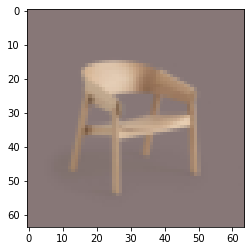

In [53]:
eval_model(model, val_dataloader)